# **SENTIMENT ANALYSIS USING BERT**

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/My Drive/BERT_Sentiment_Analysis_Project'
DATASET_PATH = f'{PROJECT_PATH}/datasets'
MODEL_PATH = f'{PROJECT_PATH}/models'
OUTPUT_PATH = f'{PROJECT_PATH}/outputs'
NOTEBOOK_PATH = f'{PROJECT_PATH}/notebooks'
REPORT_PATH = f'{PROJECT_PATH}/reports'

for path in [PROJECT_PATH, DATASET_PATH, MODEL_PATH, OUTPUT_PATH, NOTEBOOK_PATH, REPORT_PATH]:
    os.makedirs(path, exist_ok=True)
    print(f"✓ Path ready: {path}")

print("\n Google Drive successfully mounted!")
print(f" All project folders created/verified")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/datasets
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/notebooks
✓ Path ready: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/reports

✓ Google Drive successfully mounted!
✓ All project folders created/verified


# **Project Setup**

In [ ]:
import subprocess
import sys

packages = [
    'transformers',
    'torch',
    'pytorch-lightning',
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'kaggle',
    'tqdm',
    'openpyxl',
]

for package in packages:
    print(f"\nInstalling {package}...")
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f" {package} installed successfully!")
    except subprocess.CalledProcessError as e:
        print(f" Failed to install {package}: {e}")

print("\nVerifying library versions...\n")
try:
    import torch
    import transformers
    import pandas as pd
    import numpy as np

    print(f"PyTorch: {torch.__version__}")
    print(f"Transformers: {transformers.__version__}")
    print(f"Pandas: {pd.__version__}")
    print(f"NumPy: {np.__version__}")
    print("\n All imports loaded successfully!")
except Exception as e:
    print(f" Error during import verification: {e}")


Installing libraries... this may take a few minutes

Installing transformers...
✓ transformers installed successfully!

Installing torch...
✓ torch installed successfully!

Installing pytorch-lightning...
✓ pytorch-lightning installed successfully!

Installing pandas...
✓ pandas installed successfully!

Installing numpy...
✓ numpy installed successfully!

Installing scikit-learn...
✓ scikit-learn installed successfully!

Installing matplotlib...
✓ matplotlib installed successfully!

Installing seaborn...
✓ seaborn installed successfully!

Installing kaggle...
✓ kaggle installed successfully!

Installing tqdm...
✓ tqdm installed successfully!

Installing openpyxl...
✓ openpyxl installed successfully!

Verifying library versions...

PyTorch: 2.9.0+cu126
Transformers: 4.57.2
Pandas: 2.2.2
NumPy: 2.0.2

✓ All imports loaded successfully!


In [ ]:

import torch

print("GPU Information:")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"GPU Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU Only'}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


GPU Information:
CUDA Available: True
GPU Device: Tesla T4

✓ Using device: cuda
GPU Memory: 15.83 GB


# **Data Acquisition**


In [ ]:
from google.colab import files

print("Click 'Choose Files' and select your kaggle.json")
uploaded = files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)

for fn in uploaded.keys():
    with open(f'/root/.kaggle/{fn}', 'w') as f:
        f.write(uploaded[fn].decode())

os.chmod('/root/.kaggle/kaggle.json', 600)
print("✓ Kaggle API configured!")


Click 'Choose Files' and select your kaggle.json


Saving kaggle (1).json to kaggle (1) (2).json
✓ Kaggle API configured!


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import pandas as pd

api = KaggleApi()
api.authenticate()

print("Downloading dataset from Kaggle...")
api.dataset_download_files(
    'kazanova/sentiment140',
    path=DATASET_PATH,
    unzip=True
)

print(f"✓ Dataset downloaded to {DATASET_PATH}")

print("\nFiles in dataset folder:")
for file in os.listdir(DATASET_PATH):
    print(f"  - {file}")


Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
✓ Dataset downloaded to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/datasets

Files in dataset folder:
  - training.1600000.processed.noemoticon.csv
  - balanced_data.csv
  - train_data.csv
  - val_data.csv
  - test_data.csv


# **Exploratory Data Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f'{DATASET_PATH}/training.1600000.processed.noemoticon.csv',
                 header=None,
                 encoding='latin-1')

df.columns = ['Sentiment', 'Id', 'Date', 'Flag', 'User', 'Text']

print("Dataset Loaded!")
print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nColumn Info:")
print(df.info())

print(f"\nBasic Statistics:")
print(df.describe())


Dataset Loaded!

Dataset Shape: (1600000, 6)

First 5 rows:
   Sentiment          Id                          Date      Flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              User                                               Text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data 

Sentiment Distribution:
Sentiment
0    800000
4    800000
Name: count, dtype: int64

Percentage Distribution:
Sentiment
0    50.0
4    50.0
Name: proportion, dtype: float64

✓ Plot saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/01_sentiment_distribution.png


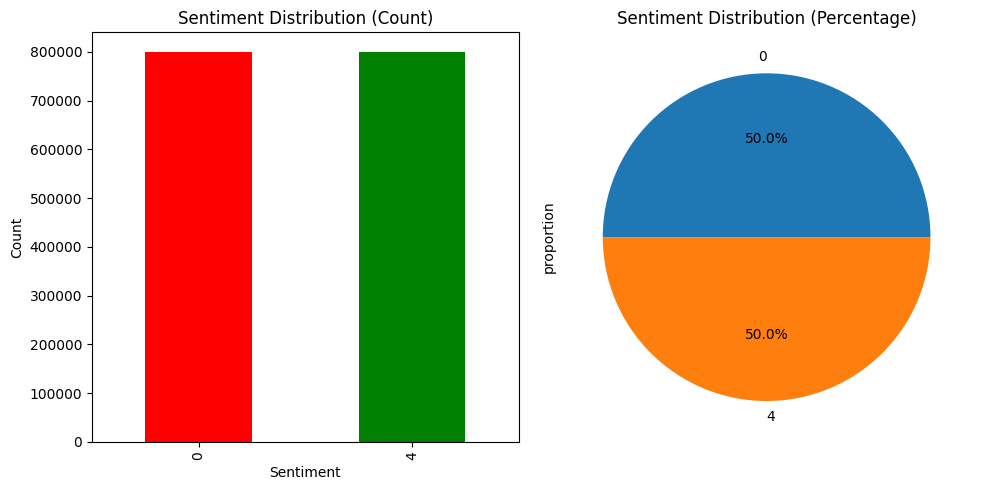

In [ ]:
print("Sentiment Distribution:")
print(df['Sentiment'].value_counts())
print(f"\nPercentage Distribution:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Sentiment'].value_counts().plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Sentiment Distribution (Count)')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['Sentiment'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution (Percentage)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/01_sentiment_distribution.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to {OUTPUT_PATH}/01_sentiment_distribution.png")
plt.show()


Text Statistics:
Average text length: 74.09 characters
Max text length: 374 characters
Min text length: 6 characters

Average word count: 13.18 words
Max word count: 64 words

✓ Plot saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/02_text_characteristics.png


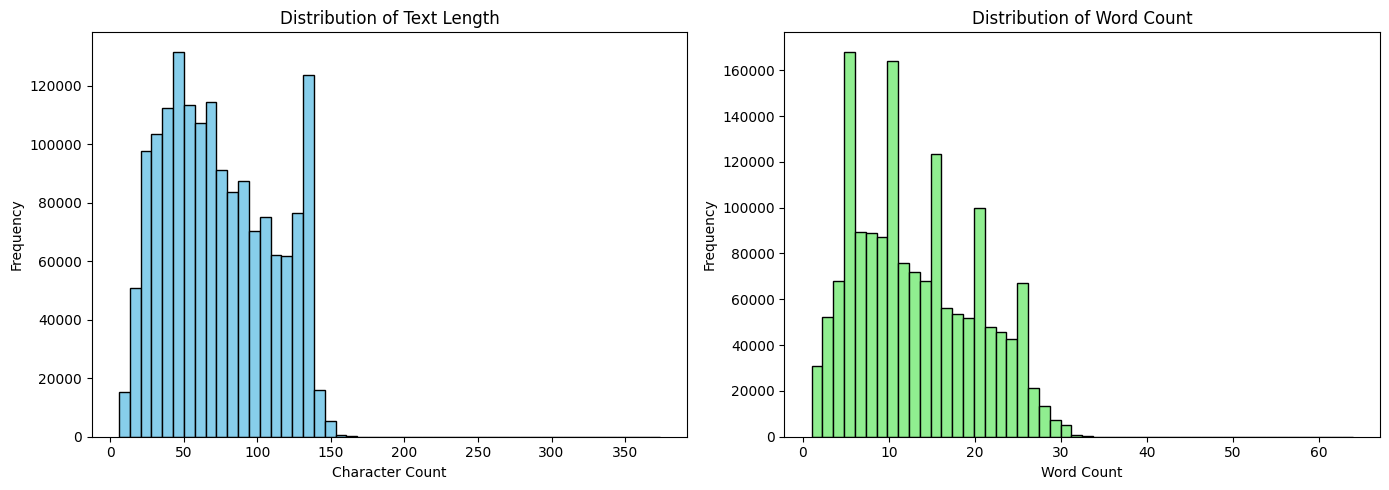

In [ ]:
df['text_length'] = df['Text'].apply(len)
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

print("Text Statistics:")
print(f"Average text length: {df['text_length'].mean():.2f} characters")
print(f"Max text length: {df['text_length'].max()} characters")
print(f"Min text length: {df['text_length'].min()} characters")

print(f"\nAverage word count: {df['word_count'].mean():.2f} words")
print(f"Max word count: {df['word_count'].max()} words")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Text Length')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Word Count')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig(f'{OUTPUT_PATH}/02_text_characteristics.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to {OUTPUT_PATH}/02_text_characteristics.png")
plt.show()


In [ ]:

print("Sample Positive Reviews:")
print("-" * 80)
for text in df[df['Sentiment'] == 4]['Text'].head(3):
    print(f"  {text[:100]}...")
    print()

print("Sample Negative Reviews:")
print("-" * 80)
for text in df[df['Sentiment'] == 0]['Text'].head(3):
    print(f"  {text[:100]}...")
    print()



Sample Positive Reviews:
--------------------------------------------------------------------------------
  I LOVE @Health4UandPets u guys r the best!! ...

  im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!...

  @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in th...

Sample Negative Reviews:
--------------------------------------------------------------------------------
  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third D...

  is upset that he can't update his Facebook by texting it... and might cry as a result  School today ...

  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds...



# **Data Preprocessing**

In [ ]:
import re
from tqdm import tqdm

df_original = df.copy()
print(f"Original dataset size: {len(df)}")

def clean_text(text):
    """
    Clean text by removing URLs, mentions, special characters, etc.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags but keep text (e.g., #covid19 -> covid19)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove extra spaces, tabs, newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("\nCleaning text data...")
df['Text'] = df['Text'].apply(lambda x: clean_text(str(x)))

print("✓ Text cleaned!")
print("\nSample cleaned texts:")
for i in range(3):
    print(f"  {df['Text'].iloc[i][:80]}...")


Original dataset size: 1600000

Cleaning text data...
✓ Text cleaned!

Sample cleaned texts:
  - a that's a bummer. you shoulda got david carr of third day to do it. ;d...
  is upset that he can't update his facebook by texting it... and might cry as a r...
  i dived many times for the ball. managed to save 50% the rest go out of bounds...


In [ ]:
from sklearn.utils import shuffle

print("Current class distribution:")
print(df['Sentiment'].value_counts())

min_samples = min(df['Sentiment'].value_counts())
sample_per_class = 10000

balanced_dfs = []
for sentiment in df['Sentiment'].unique():
    class_df = df[df['Sentiment'] == sentiment].sample(n=sample_per_class, random_state=42)
    balanced_dfs.append(class_df)

df = pd.concat(balanced_dfs, ignore_index=True)
df = shuffle(df, random_state=42)

print(f"\nBalanced dataset size: {len(df)}")
print("\nNew class distribution:")
print(df['Sentiment'].value_counts())

df.to_csv(f'{DATASET_PATH}/balanced_data.csv', index=False)
print(f"\n✓ Balanced dataset saved to {DATASET_PATH}/balanced_data.csv")


Current class distribution:
Sentiment
0    800000
4    800000
Name: count, dtype: int64

Balanced dataset size: 20000

New class distribution:
Sentiment
4    10000
0    10000
Name: count, dtype: int64

✓ Balanced dataset saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/datasets/balanced_data.csv


# **Dataset Splitting For Model Training**

In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Sentiment'])

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\nClass distribution in splits:")
print(f"Train: {train_df['Sentiment'].value_counts().to_dict()}")
print(f"Val: {val_df['Sentiment'].value_counts().to_dict()}")
print(f"Test: {test_df['Sentiment'].value_counts().to_dict()}")

train_df.to_csv(f'{DATASET_PATH}/train_data.csv', index=False)
val_df.to_csv(f'{DATASET_PATH}/val_data.csv', index=False)
test_df.to_csv(f'{DATASET_PATH}/test_data.csv', index=False)

print(f"\n✓ Data splits saved")


Train set size: 14000
Validation set size: 3000
Test set size: 3000

Class distribution in splits:
Train: {0: 7000, 4: 7000}
Val: {0: 1500, 4: 1500}
Test: {4: 1500, 0: 1500}

✓ Data splits saved


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Loading BERT tokenizer...")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"✓ Tokenizer loaded: {model_name}")

sample_text = "This movie is absolutely fantastic!"
tokens = tokenizer.encode(sample_text, add_special_tokens=True)
print(f"\nSample text: {sample_text}")
print(f"Tokens: {tokens}")
print(f"Decoded: {tokenizer.decode(tokens)}")

class SentimentDataset(Dataset):
    """
    Custom Dataset class for BERT sentiment analysis
    """
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("\n✓ Dataset class created!")


Loading BERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ Tokenizer loaded: bert-base-uncased

Sample text: This movie is absolutely fantastic!
Tokens: [101, 2023, 3185, 2003, 7078, 10392, 999, 102]
Decoded: [CLS] this movie is absolutely fantastic! [SEP]

✓ Dataset class created!


In [ ]:
import pandas as pd
train_df = pd.read_csv(f'{DATASET_PATH}/train_data.csv')
val_df = pd.read_csv(f'{DATASET_PATH}/val_data.csv')
test_df = pd.read_csv(f'{DATASET_PATH}/test_data.csv')

print("Creating datasets...")
train_dataset = SentimentDataset(
    texts=train_df['Text'],
    labels=train_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = SentimentDataset(
    texts=val_df['Text'],
    labels=val_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = SentimentDataset(
    texts=test_df['Text'],
    labels=test_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

print("✓ Datasets created!")

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ Data loaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

print("\nTesting single batch...")
batch = next(iter(train_loader))
print(f"  Input IDs shape: {batch['input_ids'].shape}")
print(f"  Attention mask shape: {batch['attention_mask'].shape}")
print(f"  Labels shape: {batch['labels'].shape}")


Creating datasets...


NameError: name 'SentimentDataset' is not defined

In [ ]:

num_classes = len(train_df['Sentiment'].unique())
print(f"Number of sentiment classes: {num_classes}")

print("\nLoading pretrained BERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False
)

model = model.to(device)

print(f"✓ Model loaded!")
print(f"\nModel Architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Size:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


NameError: name 'train_df' is not defined

# **Model and Tokenizer Setup**

In [ ]:
import torch
import gc

print("Clearing GPU memory...")

if 'model' in locals():
    del model

if 'optimizer' in locals():
    del optimizer

gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
    print(f"GPU Memory after cleanup:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
    print(f"  Total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("✓ GPU memory cleared!")



Clearing GPU memory...
GPU Memory after cleanup:
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Total: 15.83 GB
✓ GPU memory cleared!


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

print("Loading DistilBERT tokenizer and model...")

model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
    low_cpu_mem_usage=True
)

print("✓ Model loaded!")

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel Size:")
print(f"  Total parameters: {total_params:,}")
print(f"  Size: ~{total_params / 1e6:.0f} MB")

print("\nMoving model to GPU...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✓ Model on {device}!")

if torch.cuda.is_available():
    print(f"\nGPU Memory after model load:")
    print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"  Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")


Loading DistilBERT tokenizer and model...
Loading model...


NameError: name 'num_classes' is not defined

In [ ]:

#0=Negative, 1=Positive

import pandas as pd

print("Checking label values in datasets...")
print(f"Train unique labels: {sorted(train_df['Sentiment'].unique())}")
print(f"Val unique labels: {sorted(val_df['Sentiment'].unique())}")
print(f"Test unique labels: {sorted(test_df['Sentiment'].unique())}")

def create_label_mapping(df):
    """Create mapping from original labels to continuous indices"""
    unique_labels = sorted(df['Sentiment'].unique())
    label_map = {original: idx for idx, original in enumerate(unique_labels)}
    reverse_map = {idx: original for original, idx in label_map.items()}
    return label_map, reverse_map

label_mapping, reverse_label_mapping = create_label_mapping(train_df)
print(f"\nLabel Mapping: {label_mapping}")
print(f"Reverse Mapping: {reverse_label_mapping}")

print("\nApplying label mapping...")
train_df['Sentiment'] = train_df['Sentiment'].map(label_mapping)
val_df['Sentiment'] = val_df['Sentiment'].map(label_mapping)
test_df['Sentiment'] = test_df['Sentiment'].map(label_mapping)

print(f"Train labels after mapping: {sorted(train_df['Sentiment'].unique())}")
print(f"Val labels after mapping: {sorted(val_df['Sentiment'].unique())}")
print(f"Test labels after mapping: {sorted(test_df['Sentiment'].unique())}")

num_classes = len(train_df['Sentiment'].unique())
print(f"\n✓ Updated num_classes: {num_classes}")

train_df.to_csv(f'{DATASET_PATH}/train_data.csv', index=False)
val_df.to_csv(f'{DATASET_PATH}/val_data.csv', index=False)
test_df.to_csv(f'{DATASET_PATH}/test_data.csv', index=False)

print(" Updated datasets saved!")


Checking label values in datasets...
Train unique labels: [np.int64(0), np.int64(4)]
Val unique labels: [np.int64(0), np.int64(4)]
Test unique labels: [np.int64(0), np.int64(4)]

Label Mapping: {np.int64(0): 0, np.int64(4): 1}
Reverse Mapping: {0: np.int64(0), 1: np.int64(4)}

Applying label mapping...
Train labels after mapping: [np.int64(0), np.int64(1)]
Val labels after mapping: [np.int64(0), np.int64(1)]
Test labels after mapping: [np.int64(0), np.int64(1)]

✓ Updated num_classes: 2
✓ Updated datasets saved!


# **PyTorch Dataset and DataLoaders**

In [ ]:
from torch.utils.data import Dataset, DataLoader

train_df = pd.read_csv(f'{DATASET_PATH}/train_data.csv')
val_df = pd.read_csv(f'{DATASET_PATH}/val_data.csv')
test_df = pd.read_csv(f'{DATASET_PATH}/test_data.csv')

print("Verifying label ranges...")
print(f"Train: min={train_df['Sentiment'].min()}, max={train_df['Sentiment'].max()}")
print(f"Val: min={val_df['Sentiment'].min()}, max={val_df['Sentiment'].max()}")
print(f"Test: min={test_df['Sentiment'].min()}, max={test_df['Sentiment'].max()}")

print("\nRecreating datasets with fixed labels...")
train_dataset = SentimentDataset(
    texts=train_df['Text'],
    labels=train_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = SentimentDataset(
    texts=val_df['Text'],
    labels=val_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = SentimentDataset(
    texts=test_df['Text'],
    labels=test_df['Sentiment'],
    tokenizer=tokenizer,
    max_len=128
)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Data loaders recreated!")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


print("\nTesting batch...")
batch = next(iter(train_loader))
print(f"  Input IDs shape: {batch['input_ids'].shape}")
print(f"  Attention mask shape: {batch['attention_mask'].shape}")
print(f"  Labels shape: {batch['labels'].shape}")
print(f"  Label dtype: {batch['labels'].dtype}")
print(f"  Label range: {batch['labels'].min()} to {batch['labels'].max()}")

print("\n✓ All checks passed! Ready to train.")


Verifying label ranges...
Train: min=0, max=1
Val: min=0, max=1
Test: min=0, max=1

Recreating datasets with fixed labels...
✓ Data loaders recreated!
  Batch size: 8
  Train batches: 1750
  Val batches: 375

Testing batch...
  Input IDs shape: torch.Size([8, 128])
  Attention mask shape: torch.Size([8, 128])
  Labels shape: torch.Size([8])
  Label dtype: torch.int64
  Label range: 0 to 1

✓ All checks passed! Ready to train.


# **Training Configuration**

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

LEARNING_RATE = 2e-5
EPOCHS = 3
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

TOTAL_STEPS = (len(train_loader) // GRADIENT_ACCUMULATION_STEPS) * EPOCHS

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

print("Training Configuration:")
print(f"  Model: {model_name}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Gradient Accumulation: {GRADIENT_ACCUMULATION_STEPS}")
print(f"  Effective Batch Size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"  Total Steps: {TOTAL_STEPS}")
print("\n✓ Training setup complete!")


Training Configuration:
  Model: distilbert-base-uncased
  Learning Rate: 2e-05
  Epochs: 3
  Batch Size: 8
  Gradient Accumulation: 2
  Effective Batch Size: 16
  Total Steps: 2625

✓ Training setup complete!


In [ ]:
from tqdm import tqdm
import gc

def train_epoch(model, dataloader, optimizer, scheduler, device, accumulation_steps=2):
    """
    Train for one epoch with gradient accumulation for memory efficiency
    """
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    progress_bar = tqdm(dataloader, desc='Training', leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).long()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss / accumulation_steps
        logits = outputs.logits

        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            torch.cuda.empty_cache()

        total_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        correct_preds += (predictions == labels).sum().item()
        total_preds += labels.size(0)

        progress_bar.set_postfix({'loss': f'{loss.item()*accumulation_steps:.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

def validate_epoch(model, dataloader, device):
    """
    Validate model performance
    """
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validating', leave=False)

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).long()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_preds += (predictions == labels).sum().item()
            total_preds += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_preds / total_preds

    return avg_loss, accuracy

print(" Training and validation functions created!")


✓ Training and validation functions created!


# **Model Training**

In [ ]:
import json
from datetime import datetime

torch.cuda.empty_cache()

history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_model_path = f'{MODEL_PATH}/best_model.pt'
checkpoint_path = f'{MODEL_PATH}/checkpoint.pt'

print("=" * 80)
print("STARTING TRAINING - DISTILBERT + MEMORY OPTIMIZED")
print("=" * 80)
print(f"Start time: {datetime.now()}")
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Batch Size: {BATCH_SIZE}")
print("=" * 80)

try:
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 80)

        print("Training...")
        train_loss, train_acc = train_epoch(
            model,
            train_loader,
            optimizer,
            scheduler,
            device,
            accumulation_steps=GRADIENT_ACCUMULATION_STEPS
        )

        print("Validating...")
        val_loss, val_acc = validate_epoch(model, val_loader, device)

        history['epoch'].append(epoch + 1)
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))

        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"✓ Best model saved!")

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history,
            'best_val_loss': best_val_loss,
            'model_name': model_name,
            'num_classes': num_classes,
            'label_mapping': label_mapping,
            'reverse_label_mapping': reverse_label_mapping
        }
        torch.save(checkpoint, checkpoint_path)

        with open(f'{OUTPUT_PATH}/training_history.json', 'w') as f:
            json.dump(history, f, indent=4)

        print(f"✓ Checkpoint and history saved to Drive!")

        gc.collect()
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)
    print(f"Training completed at: {datetime.now()}")
    print("=" * 80)
    print(f"✓ Best model saved to: {best_model_path}")
    print(f"✓ Best validation loss: {best_val_loss:.4f}")
    print(f"✓ Training history saved!")

except RuntimeError as e:
    if "out of memory" in str(e).lower() or "cuda" in str(e).lower():
        print(f"\n{'='*80}")
        print("OUT OF MEMORY ERROR - Try these fixes:")
        print(f"{'='*80}")
        print("1. Reduce BATCH_SIZE to 4")
        print("2. Reduce dataset size (sample_per_class = 5000)")
        print("3. Restart Colab Runtime completely")
        raise
    else:
        raise


STARTING TRAINING - DISTILBERT + MEMORY OPTIMIZED
Start time: 2025-12-02 12:45:40.032622
Model: distilbert-base-uncased
Device: cuda
Batch Size: 8

Epoch 1/3
--------------------------------------------------------------------------------
Training...


Validating...



Train Loss: 0.1861 | Train Acc: 0.9379
Val Loss: 0.5441 | Val Acc: 0.8017
✓ Best model saved!
✓ Checkpoint and history saved to Drive!

Epoch 2/3
--------------------------------------------------------------------------------
Training...


Validating...



Train Loss: 0.1848 | Train Acc: 0.9357
Val Loss: 0.5441 | Val Acc: 0.8017
✓ Checkpoint and history saved to Drive!

Epoch 3/3
--------------------------------------------------------------------------------
Training...


Validating...



Train Loss: 0.1840 | Train Acc: 0.9351
Val Loss: 0.5441 | Val Acc: 0.8017
✓ Checkpoint and history saved to Drive!

Training completed at: 2025-12-02 12:56:04.086609
✓ Best model saved to: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models/best_model.pt
✓ Best validation loss: 0.5441
✓ Training history saved!


# **Model Evaluation**

✓ Training history plot saved!


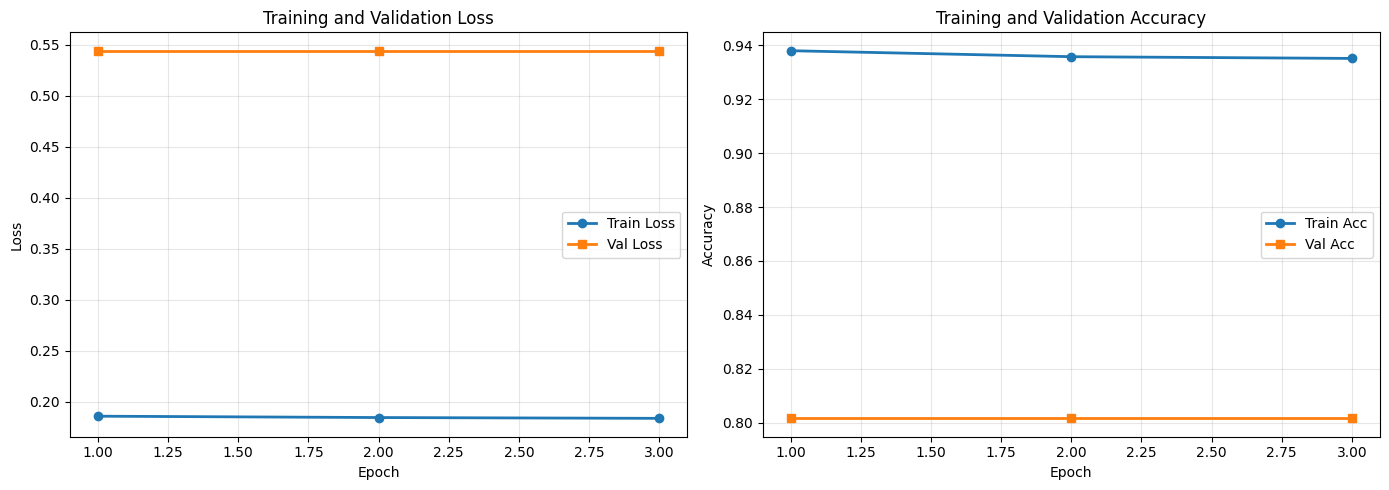

In [ ]:
import matplotlib.pyplot as plt

if len(history['epoch']) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ---------------- LOSS PLOT ----------------
    axes[0].plot(history['epoch'], history['train_loss'], marker='o', label='Train Loss', linewidth=2)
    axes[0].plot(history['epoch'], history['val_loss'], marker='s', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # ---------------- ACCURACY PLOT ----------------
    axes[1].plot(history['epoch'], history['train_acc'], marker='o', label='Train Acc', linewidth=2)
    axes[1].plot(history['epoch'], history['val_acc'], marker='s', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_PATH}/03_training_history.png', dpi=300, bbox_inches='tight')
    print(" Training history plot saved!")
    plt.show()

else:
    print("No training history to plot yet")


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.load_state_dict(torch.load(best_model_path))
print(f"✓ Best model loaded from {best_model_path}")

def get_predictions(model, dataloader, device):
    """
    Get predictions and true labels for entire dataset
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Getting predictions', leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

print("\nGenerating predictions on test set...")
test_preds, test_true = get_predictions(model, test_loader, device)

accuracy = accuracy_score(test_true, test_preds)
precision = precision_score(test_true, test_preds, average='weighted')
recall = recall_score(test_true, test_preds, average='weighted')
f1 = f1_score(test_true, test_preds, average='weighted')

print("\n" + "=" * 60)
print("TEST SET PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

print("\nDetailed Classification Report:")
print("-" * 60)
print(classification_report(test_true, test_preds))

metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'total_samples': len(test_true)
}

with open(f'{OUTPUT_PATH}/evaluation_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print(f"\n Metrics saved to {OUTPUT_PATH}/evaluation_metrics.json")


✓ Best model loaded from /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models/best_model.pt

Generating predictions on test set...



TEST SET PERFORMANCE METRICS
Accuracy:  0.8213
Precision: 0.8214
Recall:    0.8213
F1-Score:  0.8213

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1500
           1       0.83      0.81      0.82      1500

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000


✓ Metrics saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/evaluation_metrics.json


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.load_state_dict(torch.load(best_model_path))
print(f" Best model loaded from {best_model_path}")

def get_predictions(model, dataloader, device):
    """
    Get predictions and true labels for entire dataset
    """
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Getting predictions', leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return np.array(predictions), np.array(true_labels)

print("\nGenerating predictions on test set...")
test_preds, test_true = get_predictions(model, test_loader, device)

accuracy = accuracy_score(test_true, test_preds)
precision = precision_score(test_true, test_preds, average='weighted')
recall = recall_score(test_true, test_preds, average='weighted')
f1 = f1_score(test_true, test_preds, average='weighted')

print("\n" + "=" * 60)
print("TEST SET PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)

print("\nDetailed Classification Report:")
print("-" * 60)
print(classification_report(test_true, test_preds))

metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'total_samples': len(test_true)
}

with open(f'{OUTPUT_PATH}/evaluation_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print(f"\n Metrics saved to {OUTPUT_PATH}/evaluation_metrics.json")


✓ Best model loaded from /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models/best_model.pt

Generating predictions on test set...



TEST SET PERFORMANCE METRICS
Accuracy:  0.8213
Precision: 0.8214
Recall:    0.8213
F1-Score:  0.8213

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1500
           1       0.83      0.81      0.82      1500

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000


✓ Metrics saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/evaluation_metrics.json


# **Inference and Case Studies**

In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    """
    Predict sentiment for a single text
    """
    model.eval()

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    return prediction.item(), probabilities.cpu().numpy()

sentiment_mapping = {
    0: 'Negative',
    1: 'Positive'
}

print("Inference function ready!")


✓ Inference function ready!


In [ ]:
print("=" * 80)
print("SENTIMENT ANALYSIS - INFERENCE EXAMPLES")
print("=" * 80)

results = []

for text in test_samples:
    pred_label, probabilities = predict_sentiment(text, model, tokenizer, device)
    sentiment = sentiment_mapping.get(pred_label, f"Class {pred_label}")

    confidence = float(probabilities.max()) * 100

    print(f"\nText: {text}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")

    results.append({
        'text': text,
        'predicted_label': pred_label,
        'predicted_sentiment': sentiment,
        'confidence': confidence
    })

with open(f'{OUTPUT_PATH}/inference_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n Inference results saved to {OUTPUT_PATH}/inference_results.json")


SENTIMENT ANALYSIS - INFERENCE EXAMPLES

Text: This movie was absolutely amazing! I loved it so much!
Predicted Sentiment: Positive
Confidence: 98.61%

Text: Terrible product. Total waste of money. Never buying again.
Predicted Sentiment: Negative
Confidence: 98.98%

Text: It's okay, nothing special. Average experience.
Predicted Sentiment: Positive
Confidence: 98.81%

Text: Best purchase I've ever made! Highly recommended!
Predicted Sentiment: Positive
Confidence: 99.15%

Text: Worst experience ever. Very disappointed.
Predicted Sentiment: Negative
Confidence: 99.20%

✓ Inference results saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/inference_results.json


In [ ]:
print("Running batch inference on test set...")
batch_results = []
for idx in range(min(100, len(test_df))):
    text = test_df.iloc[idx]['Text']
    true_label = test_df.iloc[idx]['Sentiment']

    pred_label, probs = predict_sentiment(text, model, tokenizer, device)
    true_sentiment = sentiment_mapping.get(true_label, f"Class {true_label}")
    pred_sentiment = sentiment_mapping.get(pred_label, f"Class {pred_label}")

    batch_results.append({
        'text': text,
        'true_label': true_label,
        'true_sentiment': true_sentiment,
        'predicted_label': pred_label,
        'predicted_sentiment': pred_sentiment,
        'confidence': float(max(probs) * 100),
        'correct': true_label == pred_label
    })

batch_accuracy = sum([r['correct'] for r in batch_results]) / len(batch_results)
print(f"\nBatch Inference Accuracy (100 samples): {batch_accuracy * 100:.2f}%")

batch_df = pd.DataFrame(batch_results)
batch_df.to_csv(f'{OUTPUT_PATH}/batch_predictions.csv', index=False)
print(f"Batch predictions saved to {OUTPUT_PATH}/batch_predictions.csv")

print("\nSample predictions:")
print(batch_df[['text', 'predicted_sentiment', 'confidence', 'correct']].head(10))



Running batch inference on test set...

Batch Inference Accuracy (100 samples): 73.00%
✓ Batch predictions saved to /content/drive/My Drive/BERT_Sentiment_Analysis_Project/outputs/batch_predictions.csv

Sample predictions:
                                                text predicted_sentiment  \
0                                      dyed my hair.            Positive   
1  : danny. please please please say 'ich liebe d...            Negative   
2                             my mommy is the bessst            Positive   
3  haveyouever tried to start a trending topic? i...            Positive   
4  is ready for tomorrow! hopefully it's a good d...            Negative   
5  i remember reading that book in college...all ...            Positive   
6  should standing up to what you believe in lead...            Negative   
7  just realized that jamba juice raised their pr...            Negative   
8                         too bad im no longer first            Negative   
9               

In [ ]:
import os
import torch
from google.colab import drive
from transformers import AutoModelForSequenceClassification, AutoTokenizer

drive.mount('/content/drive', force_remount=False)

PROJECT_PATH = '/content/drive/My Drive/BERT_Sentiment_Analysis_Project'
DATASET_PATH = f'{PROJECT_PATH}/datasets'
MODEL_PATH   = f'{PROJECT_PATH}/models'
OUTPUT_PATH  = f'{PROJECT_PATH}/outputs'
NOTEBOOK_PATH = f'{PROJECT_PATH}/notebooks'
REPORT_PATH   = f'{PROJECT_PATH}/reports'

for path in [PROJECT_PATH, DATASET_PATH, MODEL_PATH, OUTPUT_PATH, NOTEBOOK_PATH, REPORT_PATH]:
    os.makedirs(path, exist_ok=True)

print("PROJECT_PATH:", PROJECT_PATH)
print("MODEL_PATH:", MODEL_PATH)

model_name = "distilbert-base-uncased"
num_classes = 2                          # 0=Negative, 1=Positive

print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("✓ Tokenizer ready")

print("\nRebuilding DistilBERT model architecture...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)
print("✓ Base DistilBERT model created")

best_ckpt_path = os.path.join(MODEL_PATH, "best_model.pt")
print("\nLoading best checkpoint from:", best_ckpt_path)

state_dict = torch.load(best_ckpt_path, map_location=device)
load_result = model.load_state_dict(state_dict, strict=True)  # strict=True to ensure exact match
print("✓ Best model weights loaded:", load_result)

model.eval()
INFERENCE_DIR = os.path.join(MODEL_PATH, "inference_export")
os.makedirs(INFERENCE_DIR, exist_ok=True)

print("\nExporting model and tokenizer to:", INFERENCE_DIR)
model.save_pretrained(INFERENCE_DIR)
tokenizer.save_pretrained(INFERENCE_DIR)
print("✓ Export complete. Inference assets ready.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_PATH: /content/drive/My Drive/BERT_Sentiment_Analysis_Project
MODEL_PATH: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models

Loading tokenizer...
✓ Tokenizer ready

Rebuilding DistilBERT model architecture...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Base DistilBERT model created

Loading best checkpoint from: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models/best_model.pt
✓ Best model weights loaded: <All keys matched successfully>

Exporting model and tokenizer to: /content/drive/My Drive/BERT_Sentiment_Analysis_Project/models/inference_export
✓ Export complete. Inference assets ready.
